# Bayesian Blocks Algorithm

*Sara Munafò, MAT: 2072380 -  Advanced Statistics for Physics Analysis (A.A. 2023/24)*

In [2]:
library(dplyr)
library('FITSio')

# 1. Introduction

The Bayesian Blocks algorithm, firstly proposed by Scargle et. al in 1998 [1] and perfected in 2013 [2], focuses on detecting and characterizing local variability in sequential data.    
The goal of the algorithm  is that of identify statistically significant variations in the data, while at the same time suppressing variations cause by observational errors.

[1] J.D.Scargle et al., Astrophys.J.504 (1998) 405    

[2] J.D.Scargle et al., Astrophys.J.764 (2013) 167

## 1.1 Main idea

In data analysis, one of the most common tools that help to visually detect statistical significancy in the data is that of producing histograms.   
The main problem of histograms, however, is that their visualization higly relies on the number of bins selected and their widths, which are both tunable parameters that have to be selected manually; this general approach may lead either to overfitting of the data (if the bin width is too small), or to the loss of important statistical features if the bin width is too large. At the same time, there isn't a general way to select the bin's edges, which are usually taken to be equidistant.     

The Bayesian Blocks algorithm's main idea is that of learning the optimal **block representation** of the given data from the data itself, exploring the space of all possible **partitions** and selecting the optimal **change-points** locations.       
The algorithm is non-parametric, which guarantees a generic representation and a relatively low complexity, and convergence is guaranteed.
    
By far, one of the main advantages of the algorithm is its computational time.
Given a dataset of $N$ observations, the number of possible partitions  is $2^N$ .This number renders an explicit exhaustive search of partition space utterly impossible for all but very small $N$.    
The Bayesian Blocks algorithm implicitly performs a complete search of this space in time of order $N^2$ , and is practical even for very large N. 
<div class="alert alert-block alert-info">
<b>Computational time:</b> The algorithm finds the optimum among all partitions without an exhaustive explicit search, which is obviously impossible for almost any value of N arising in practice, in time of order $N^2$.
</div>


There are more than one model to choose for the Bayesian blocks algorithm:
- The piecewise constant model
- The linear model
- The exponential model    

For the purposes of this project, I will focus on the piecewise contant model, which is the one with lower complexity.

## 1.2 Piecewise constant model

In the piecewise contant model, the range of the independent variable (e.g., time) is divided into subintervals, called <font color='orange'>**blocks**</font>, generally unequal in size, in which the dependent variable (e.g., intensity) is modeled as constant within errors.

Defining the <font color='orange'>**change points**</font> as the points between two blocks, the model contains the following parameters:
- $N_{cp}$  : number of change points
- $t_k^{cp}$ : the change-point at the start of block $k$ 
- $X_k$  : the signal amplitude in block $k$    

The first data point is always considered a change points, and the number of blocks is always one more than the number of edges : $N_{\text{blocks}}=N_{cp}+1$

The goal of the algorithm will be that of selecting the optimal number of block and change points locations, based on the optimization of a <font color='orange'>**fitness function**</font> associated with each possible partition.

The key idea is that the blocks can be treated independently, in the sense that a block’s fitness depends only on the data it contains.    
The model for each block has effectively two parameters.
- The signal amplitude, which  is treated as a nuisance parameter to be determined after the change points have been located. 
- The length of the interval spanned by the block

<div class="alert alert-block alert-info">
<b>$N_{\text{blocks}}$ prior:</b> The number of blocks will be determined by defining a prior distribution for it.
</div>

## 1.3 Data modes

The algorithm can be used with a variety of data types, called <font color='orange'>**data modes**</font>.
The three most common data modes are: 
1. **TTE (time-tagged events)** : times of specific events;
2. **Binned events**: counts of events in time bins;
3. **Point measurements**: measurements of a quasi-continuous observable at a sequence of points in time.    

These data modes can be equally analyzed through the Bayesian Blocks algorithm, the only difference between them is their statistics.

The data mode influences the prior used for the number of blocks, as well as the fitness function. For this project, I will mainly work with TTE, experimenting also with Point Measurements data.    

# 2. The Algorithm

## 2.1 Definitions

- **Partition** : Collections of non-overlapping blocks, defined by specifying the number of its blocks and the block edges;
- **Data cells** : Input of the algorithm; each data cell usually contains a single measurements, with its time information;
- **Blocks** : A set of consecutive cells, grouped together by the algorithm; a block can be as small as one cell, and as large as the whole dataset. All parameters of the model are constant within each block, and undergo discrete jumps at the change points; the height of each block is equal to the signal intensity averaged over the interval;
- **Change points**:  the points that signal the end of a block and the start of a new one. they can coincide with data points.

## 2.2 Prior
In most settings it is much more likely a priori that $N_{\text{blocks}} <<N$ than that $N_{\text{blocks}} ≈ N$.    

For this reason it is desirable to impose a prior that assigns smaller probability to a large number of blocks. A geometric prior (Coram 2002) with the single parameter $\gamma$ is adopted: $$\begin{cases}P(N_{\text{blocks}})=P_0\gamma ^{N_{\text{blocks}}} \quad 0\leq N_{\text{blocks}} \leq N \\
0 \qquad otherwise
\end{cases}$$
Where $P_0=\dfrac{1-\gamma}{1-\gamma^{N+1}}$.    

The choice of the parameter $\gamma$ effects the representation, and the optimal value will vary depending on the data.    
This parameter controls the <font color='orange'>**false positive rate**</font>—i.e., the probability $p_0$ of falsely reporting detection of a change point. The desired correct detection rate can be tuned (lower values lead to less overfitting of the data), and it is usually  set to $p_0=0.05$. In the case of Point measurements, however, $p_0$ has no effect on the prior. 

Although other choices for the prior are possible, one of the advantages of this choice is the ease of implementation: since we will work with logarithms, the contribution of the prior to block fitness can be easily implemented by adding the constant *ncp_prior*=$\log \gamma$ to the fitness of each block.    
   

For TTE and Point measurements, the optimal values of this constant (which only depends on the number of observations $N$ and the correct detection rate $p_0$) were determined as the result of a series of simulations performed in the original paper as:
- $4-\log\left(73.53\cdot p_0 \cdot N^{(-0.478)}\right)$  for TTE
- $1.32 + 0.577 \cdot \log_{10}(N)$  for Point Measurements    

In [3]:
ncp_prior <- function(gamma=NULL, N, p0 = .05, data_type){ 
    if (is.null(gamma)){
      if(data_type == "TTE"){
         return(4 - log(73.53 * p0 * (N**-0.478)))
      }
      if(data_type == "PM"){
      return( 1.32 + 0.577 * log10(N))
      }}
}

## 2.3 Fitness function

The algorithm selects the optimal partition $P(T)$ by maximizing a quantity measuring the fitness of models in the given class ( in this case, the class of all piecewise constant models).    
The most impoprtant property of the fitness function is that it is <font color='orange'>**block-additive**</font>, i.e.: $$F(P(T))=\sum_{k=1}^{N_{\text{blocks}}}f(B_k)$$
so the block-fitnesses (computed for each block separately) are added up to compute the total fitness.    
<div class="alert alert-block alert-info">
<b>Note on block-additivity</b> By considering a block-additive fitness function, we ignore the possibility of correlated errors, so that the fitness of one block does not depend on the fitness of its neighbours.
</div>

The block fitness function is a measure of how well the constant signal represents the data in the block, and its expression varies depending on the data mode.    
##### For TTE:  
If $M(t,\theta)$ is a model of the time dependence of a signal, with $\theta$ the parameters of the model, the unbinned log-likelihood (Cash statistics) is: $$\log L(\theta)=\sum_n \log M(t_n,\theta)-\int M(t,\theta)dt$$
where the sum is over the events, and the integral (over the observation interval) is the expected number of events under the model.    
In our case, the only parameter is $\lambda$, the rate of events, so we obtain (for each block $k$: $$\log L^{(k)}=N^{(k)}\log \lambda - \lambda T^{(k)}$$
where:
- $N^{(k)}$  : number of events in block $k$
- $T^{(k)}$  : length of block $k$
    

The maximum of the likelihood is obtained where $\lambda=N^{(k)}/T^{(k)}$, so we get the final expression $$\boxed{\log L_{\text{max}}^{(k)}+N^{(k)}=N^{(k)}(\log N^{(k)} - \log T^{(k)})}$$

##### For Point Measurements:
In point measurements, we measure a signal $s(t)$ at subsequent times $t_n, n=1,2,...N$, which will inevitably be corrupted by observational errors.    
Considering these errors random and additive, we can model the observations as: $$x_n=x(t_n)=s(t_n)+z(t_n), \quad n=1,2,...,N$$
Assuming these errors follow a normal probability distribution with zero mean and a given variance $z_n \sim \mathcal{N}(0,\sigma_n)$, if the model signal is the constant $s=\lambda$, the likelihood of the n-th measurement is given by:
$$L_n=\dfrac{1}{\sigma_n \sqrt{2 \pi}}e^{-\frac{1}{2}\left(\frac{x_n - \lambda}{\sigma_n}\right)^2}$$
Assuming independence of the measurements, the block-likelihood of block $k$ is given by: $$L^{(k)}=\prod_n L_n=\dfrac{(2\pi)^{-N^{(k)}/2}}{\prod_m \sigma_m} e^{-\frac{1}{2}\sum_n\left(\frac{x_n - \lambda}{\sigma_n}\right)^2}$$

Defining
$$a_k=\dfrac{1}{2} \sum_n \dfrac{1}{\sigma_n^2}, \qquad b_k = -\sum_n \dfrac{x_n}{\sigma_n^2}$$   

the value of $\lambda$ maximizing the likelihood is $\lambda=-b_k/2a_k$
Then the maximum likelihood expression is: $$\boxed{\log L_{\text{max}}^{(k)}=b_k^2/4a_k}$$

In [4]:
block.fitness = function(N_k, T_k, dt, a_k, b_k, data_type){
    if (data_type=='TTE'){
        return(N_k * log(N_k/T_k))
    }
    else{return( (b_k^2)/(4*a_k))}
}

## 2.4 Main algorithm

The algorithm works one data cell at a time, using results stored from all previous steps; the value of optimal fitness is stored in array *best*, while the location of the last change point of the optimal partition is stored in array *last*.


##### -  Part 1: fitness of all possible partitions
Starting from the first data cell $R=1$, $P^{opt}(1)$ is the only possible partition (one block consisting on the first cell itself).
At iteration $R+1$:
- consider the set of all possible partitions of these $R+1$ cells whose last block starts at cell $r$ (for a range of $r$ values) and ends at cell $R+1$. The fitness of this last block is denoted as $F(r)$;
- The only element of this set that could possibly be optimal is that consisting of the optimal partition up to $r-1$, $P^{opt}(r-1)$ followed by this last block from $r-1$.
- By the additivity, the fitness of said partition is the sum of these fitnesses: $$A(r) = F(r) + \begin{cases} 0 \quad r=1\\ \text{best}(r-1), \quad r=2,3,...,R+1 \end{cases}$$
    
##### -  Part 2: selecting optimal partition
Since we want to maximize the fitness, we have to find the $r^{(\text{opt})}$ (index at which the last block starts) as: $$r^{(\text{opt})}=\text{argmax} [A(r)]$$
At the end of the computation, when $R = N$ , it only remains to
find the final locations of the change points of the optimal partition.
The information is contained in the array *last* in which
we have stored the index $r^{(\text{opt})}$ at each step.    
We use the last value in this array to determine the last change point in $P^{opt}(N)$, peel off the end section of *last* corresponding to this last block, and repeat:
- $cp_1=\text{last}(N)$ 
- $cp_2 = \text{last}(cp_1-1)$
- $cp_3 = \text{last}(cp_2-1)$
- ...

In [5]:
bayesian_blocks = function(data, gamma, dt, data_type, bool_time, p0){

    #----------------------------------------------------------------------------------------------------------
    # Preliminary setup
    #----------------------------------------------------------------------------------------------------------
    start_time <- Sys.time()
    
    # define cells
    t <- unique(data[,1])
    N <- length(t)
    
    # count events happening at the same time for TTE data
    if(data_type=='TTE'){x <- as.vector(table(data[,1]))}
    
    # define x, sigma and quantities needed for the computation of a_k, b_k for Point measurements
    if(data_type=='PM'){  
        x <- data[,2]
        sigma = data[,3]
        
        ak_raw = rep(x = 1, times=length(x))/sigma**2
        bk_raw = x/sigma**2
        ck_raw = (x*x)/sigma**2
    }

    #initial edges
    edges = c(t[1],  0.5 * (t[2:N] + t[1:(N-1)] ), t[N])
    block_length = t[N] - edges 
    #to store values
    best = rep(0, times = N)
    last = rep(1, times = N)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------

    for (k in seq(1:N)){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        T_k <- block_length[1:k] - block_length[k + 1] #T_K
        N_k <- rev(cumsum(rev(x[1:k]))) #N_K  
        ncp_ = ncp_prior(gamma, N, p0=p0, data_type=data_type)

        if (data_type =='PM' ){
            a_k = 0.5*rev(cumsum(rev(ak_raw[1:k])))
            b_k = -1 * rev(cumsum(rev(bk_raw[1:k])))
        }

        fitness = block.fitness(N_k, T_k, a_k=a_k, b_k=b_k, dt=dt, data_type)
        post_vec = fitness - ncp_
        post_vec[2:k] = post_vec[2:k] + best[1:(k-1)]

        #Cell at which to start the kth block
        r_opt = which.max(post_vec)
        last[k] = r_opt
        best[k] = post_vec[r_opt]
    }

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------

    change_points <- matrix(0,nrow=1,ncol=N)
    i_cp          <- N + 1
    ind           <- N + 1
    
    while(TRUE){
        i_cp <- i_cp - 1 
        change_points[i_cp] <- ind 
        if(ind==1){
            break 
            }
        ind <- last[ind-1]        
    }
    
    change_points <- change_points[(i_cp):N]
    if(bool_time){
        end_time <- Sys.time()
        exec_time <- as.numeric(end_time - start_time)
        return(exec_time)
    }
    return(edges[change_points])
}    
     

## 2.5 Computational time

After the implementation of the main algorithm, I implemented the following function to verify the computational time; as stated in the introduction, the execution time of the Bayesian Block algorithm should go as $N^2$, given $N$ observations.

In [6]:
#Function to calculate computational time for normal distribution, varying N
comp_time <- function(N_seq,mean,sig,data_type) {
    time_list <- c()
    for(i in 1:length(N_seq)){
        data <- rnorm(N_seq[i],mean,sig)
        data <- data[order(data)] %>% as.data.frame()
        time_list[i] <- bayesian_blocks(data, gamma=NULL, dt=NULL, data_type=data_type, bool_time=TRUE, p0=.05)
        }
    return(time_list)
    }


## 2.6 Bootstrap analysis

Finally, before heading to the testing part of the algorithm, I focused on the variance analysis of the block light-curve representation.    
To treat uncertainty in the Bayesian Blocks algorithm, there are three main aspects on which one can focus on:
1. The full block representation
2. The presence of the change points
3. The locations of the change points
    
The bootstrap analysis tackles the first aspect: it provides an indicator of the <font color='orange'>**uncertainty of the block light-curves**</font> obtained through the algorithm, yielding statistics such as mean and variance.      

The procedure works as follows:
##### - Part 1: running bayesian blocks
- Select a number of bootstrap samples, $N_{\text{samp}}$;
- Each bootstrap sample is obtained through resampling (with replacement) of the original dataset;
- The Bayesian Blocks algorithm is applied to each bootstrap sample (providing a set of edges and counts for each sample);
    
At the end of this first part, a set of $N_{\text{samp}}$ pairs of lists with edges (*edges_list*) and counts (*counts_list*) is obtained.

##### - Part 2: computing mean and variance
- A common set of evenly spaced times is chosen;
- At each time, the *count* value for each bootstrap sample at that time is retrieved, and  stored in the *counts_matrix* matrix;
- The mean and variance of the counts at each of the chosen times is computed from the matrix's columns.


In this way, the obtained block representation from a given dataset, is accompanied by its mean and variance.

In [7]:
# Function to compute heights
#bb: bayesian block edges
#data: input data
steps <- function(bb,data){
    step <- c()
    for(i in seq(1:length(bb)-1)){
        selected <- data[data[[1]]>=bb[i] & data[[1]]<bb[i+1],]
        step[i] <- selected[[2]] %>% mean()
    }
    return(step)
}

In [8]:
bootstrap_analysis <- function(N_samp,data,size_samp,data_type,p0, bin_width){
    #--------------------------------------------------------------
    # Bayesian block to N_samp bootstrap samples
    #--------------------------------------------------------------
    edges_list <- c()
    counts_list <- c()

    for (n in seq(1,N_samp)){

        # create the bootstrap sample
        sample_b <-  data[sample(nrow(data), size=size_samp, replace=TRUE), ]
        sample_b <- sample_b[order(sample_b[,1]),]
    
        # Bayesian blocks + add new edges to bootstrap edges_list
        edges_new <- bayesian_blocks(sample_b, gamma=NULL, dt=NULL, data_type=data_type,bool_time=FALSE,p0=p0)
        edges_list[n] <- list(edges_new)
        
        # counts are computed from the histogram for TTE, through the step function for PM
        if(data_type=='TTE'){
            counts_list[n] <- list(hist(sample_b[,1],breaks=edges_new, plot=F)$counts)
            }
        else{counts_list[n] <- list(step_ <- steps(edges_new,sample_b))}
    }
    
    
    # choose time subdivision on which to compute mean and variance
    # making sure that the interval includes the mins and maxs edges of each bootstrap sample
    min_list <- c()
    max_list <- c()
    for(j in 1:length(edges_list)){
        min_list[j] <- min(edges_list[[j]])
        max_list[j] <- max(edges_list[[j]])
    }
    t_min <- max(min_list)
    t_max <- min(max_list)
    
    #-------------------------------------------------------------
    # Compute statistical properties
    #-------------------------------------------------------------
    
    selected_times <- seq(t_min,t_max, by=bin_width)

    counts_matrix <- matrix(0, nrow = length(edges_list), ncol = length(selected_times)-1)

    # i: time index;  j: bootstrap sample index
    for(i in 2:(length(selected_times)-1)){
        for(j in 1:length(edges_list)){
            edges <- edges_list[[j]]
            counts <- counts_list[[j]]
            
            #border conditions
            counts[length(edges)] <- counts[length(edges)-1]
            counts_matrix[j,1] <- counts[1]
            
            if(any(edges<=selected_times[i]&edges>selected_times[i-1])){
                 index <- which(edges<=selected_times[i] & edges>selected_times[i-1])
            }else{index <- which(edges==max(edges[edges<=selected_times[i]]))}
       
            counts_matrix[j,i] <- mean(counts[index])
            }
        }
    
    mean_counts <- colMeans(counts_matrix)
    var_counts <- apply(counts_matrix, 2, var)
    
    # add last value to avoid dimension problems when plotting
    mean_counts <- c(mean_counts,mean_counts[length(mean_counts)])
    var_counts <- c(var_counts,var_counts[length(var_counts)])

    # constant to compute densities for TTE histogram
    const <- sum(mean_counts)*bin_width
    
    # compute values at +- 1 sigma
    sig_counts <- sqrt(var_counts)
    plus_sig <- mean_counts + (sig_counts)
    minus_sig <- mean_counts - (sig_counts)
    
    if(data_type=='TTE'){
        return(list(sel_times=selected_times, means=mean_counts/const,sigma_p =plus_sig/const, sigma_m=minus_sig/const))
    }else{
        return(list(sel_times=selected_times, means=mean_counts,sigma_p =plus_sig, sigma_m=minus_sig))
    }
    
    
}

# 3. Testing the algorithm

In the preliminary testing part, two tests are performed:
- The test of the algorithm 
- The test of the computational time

## 3.1 Testing the algorithm

The first test, to see how the algorithm performs with a controlled dataset, I worked with data composed by two gaussian signals and a background uniform noise.

In [9]:
set.seed(124)
noise <- runif(1e4,0,10)
norm1 <- rnorm(1e3,2,0.7)
norm2 <- rnorm(1e3,7,0.4)
signal <- c(norm1,norm2,noise)

data <- signal[order(signal)] %>% as.data.frame()

In [10]:
N <- length(data[,1])
bb <- bayesian_blocks(data, gamma=NULL, dt=NULL, data_type='TTE',bool_time=FALSE,p0=.05)

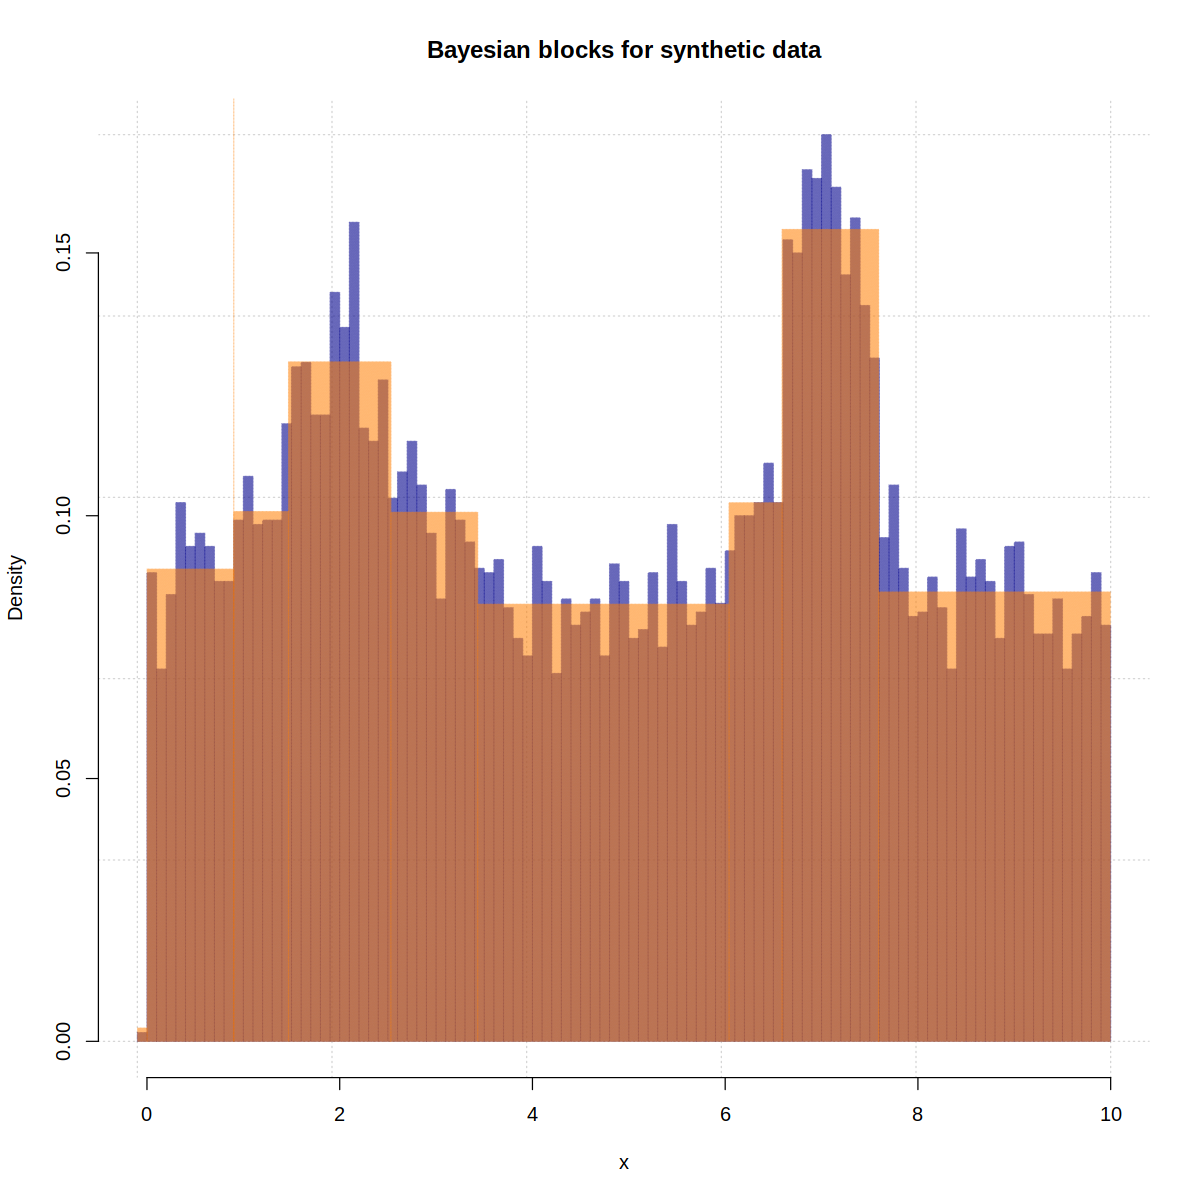

In [11]:
options(repr.plot.height=10, repr.plot.width=10)
hist(data[,1],breaks=sqrt(N),freq=FALSE,col=scales::alpha('darkblue',.55),border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Density', main=paste('Bayesian blocks for synthetic data'))
hist(data[,1],breaks=bb,density=200,
     freq=FALSE,col=scales::alpha('darkorange1',.5),border=F,add=T)

## 3.2 Test of computational time

To visualize the dependence of execution time on the number of observations in the dataset, I tested the algorithm on a set of increasingly large dataset, following a gaussian distribution with fixed mean and variance.

In [12]:
set.seed(123)
# compute sequence of N to test
N_seq <- c(1e2,seq(1e3,1e4,by=1e3)) 
mean <- 0
sig <- .5
times <- comp_time(N_seq,mean,sig,data_type='TTE')

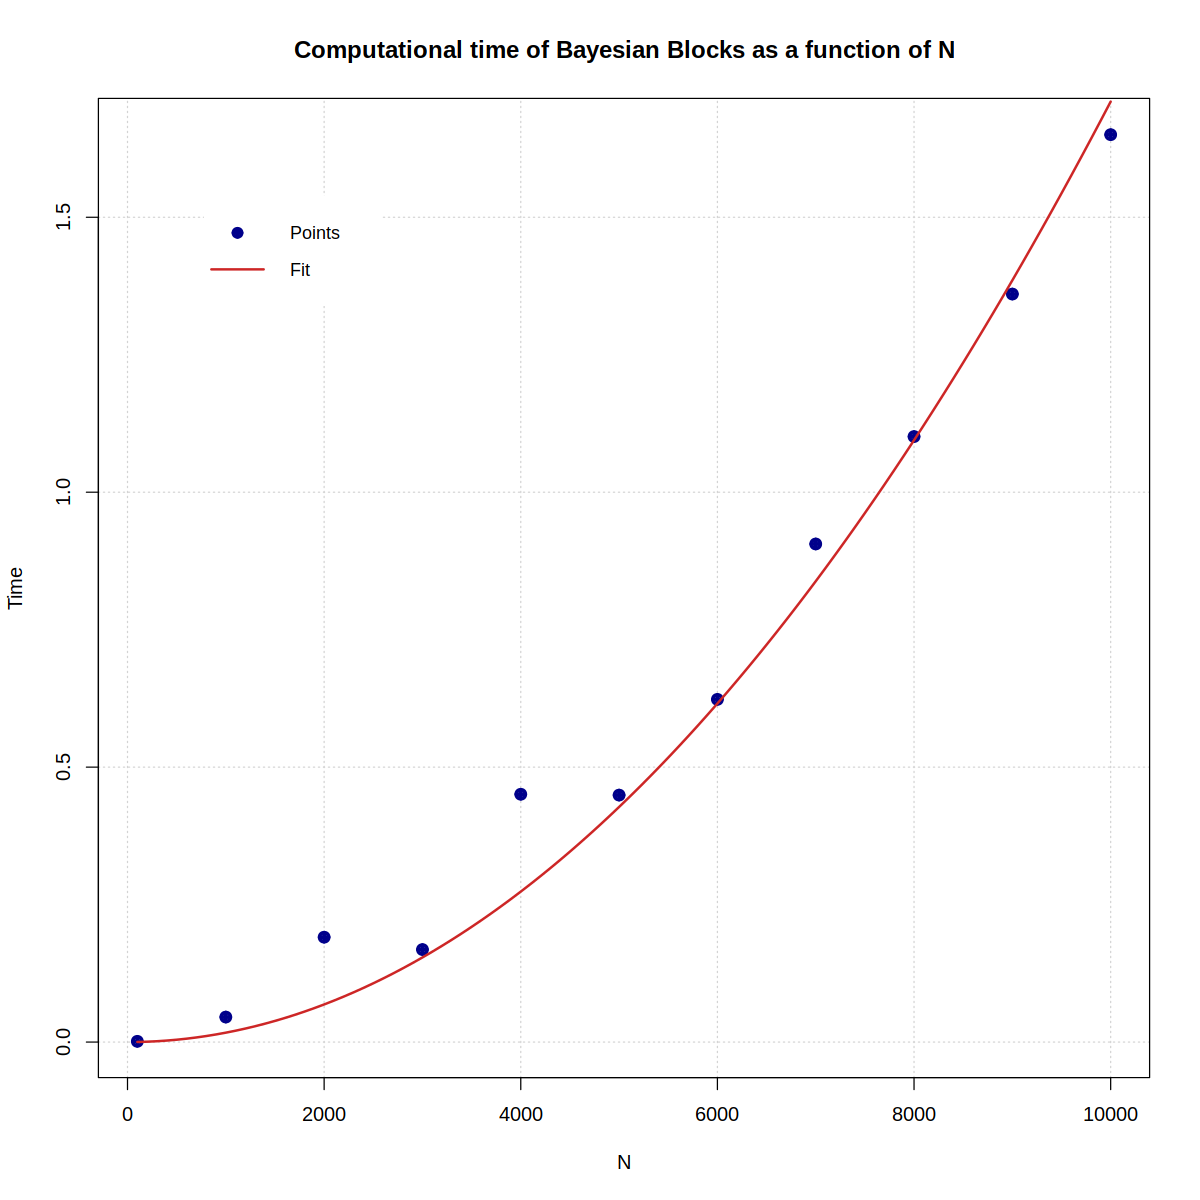

In [13]:
x <- N_seq
y <- times

# second order fit
fit2 <- lm(y ~ 0 + I(x^2))
xx <- seq(1e2,1e4,by=1e2)
yy <- predict(fit2,data.frame(x=xx))

# set the size and position of the plots
options(repr.plot.width=10, repr.plot.height=10)

plot(x,y,xlab='N',ylab='Time',col='darkblue',pch=10,panel.first=grid(),
     lwd=3,main='Computational time of Bayesian Blocks as a function of N')
lines(xx, yy, col = "firebrick3",lwd=2)
legend("topleft", inset=+0.1,legend=c("Points","Fit"),
       col=c("darkblue","firebrick3"),lty=c(NA,1), pch=c(10,NA),lwd=c(3,2), cex=0.9,box.lty=0, border=F)

# 4. Applications

After testing the algorithm with synthetic data, it's time to work with real datasets.
I chose two datasets:
- The BATSE dataset: consisting of TTE
- The KEPLER dataset : consisting of Point Measurements

## 4.1 BATSE TTE data

The Burst and Transient Source Experiment (BATSE) on the Compton Gamma Ray Observatory (CGRO) was designed to study gamma-ray bursts (GRBs) and other transient phenomena in the gamma-ray sky. The BATSE dataset was also used by Scargle et.al. in the reference paper [2].

The dataset [3] consists of ascii files, separated into different directories depending on the specific Trigger.
The ASCII files consist of:
- **time-tags** : a first array collecting time tags for all photons detected in the gamma-ray burst. 
- **channels** : a second array with the associated energy channel (1,2,3 or 4); each channel corresponds to a different range of detected energy: 
    1. **Channel 1:** 20 keV to 50 keV
    2. **Channel 2:** 50 keV to 100 keV 
    3. **Channel 3:** 100 keV to 300 keV
    4. **Channel 4:** 300 keV to 1 MeV

In particular, I selected data from the Trigger 551, performing an analysis both on the whole dataset and on each channel separately.

[3] https://heasarc.gsfc.nasa.gov/FTP/compton/data/batse/ascii_data/batse_tte/

In [13]:
# Function to load the ascii file and format the data in the appropriate way;
# the select_ch parameter allows to select a specific channel

format.events <- function(file_path,select_ch){
    # load ascii file and extract data
    file <- as.data.frame(read.table(file_path, header=TRUE, sep='\t'))
    npts <- as.numeric(sub("npts = *", "", file[1,1]))
    file1 <- file[5:nrow(file),] %>% as.data.frame()
    names(file1) <- 'col'

    # turn into one-dimensional array and remove NAs
    one_dim <- unlist(strsplit(file1$col, " ")) %>% as.numeric()
    one_dim <- one_dim[!is.na(one_dim)] 

    # extract time and channel information
    times <- one_dim[1:npts]
    ch <- one_dim[npts+1:npts*2]
    
    # return dataframe with pairs of (time,channel)
    
    data <- data.frame('time'=times, 'channel'=ch)
    # select specific channel if specified
    if(select_ch!=-1){
        data <- data[data$channel==select_ch,]
    }   
    return(data)
}

### 4.1.1. All channels

In [14]:
path <- 'batse_tte/tte00000/tteascii.00551'
data <- format.events(path,select_ch=-1)

In [15]:
bb <- bayesian_blocks(data, gamma=NULL, dt=NULL, data_type='TTE',bool_time=FALSE,p0=.05)

In [16]:
N <- length(data$time)

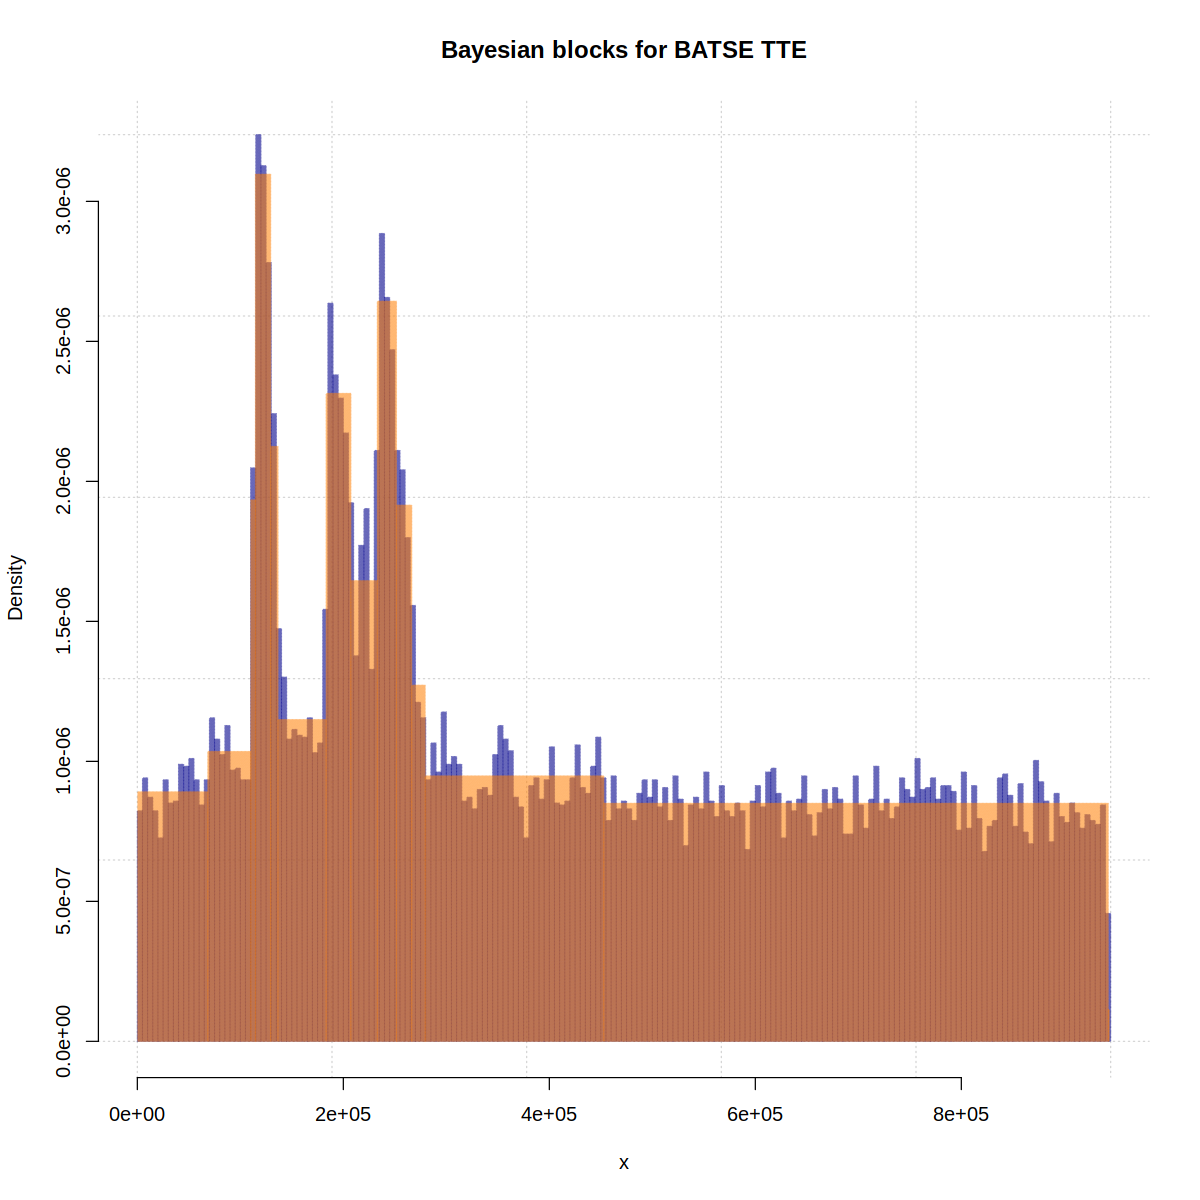

In [17]:
options(repr.plot.width=10,repr.plot.height=10)
hist(data$time, breaks=sqrt(N),freq=FALSE,col=scales::alpha('darkblue',.55),border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Density',main=paste('Bayesian blocks for BATSE TTE'))
hist(data$time,breaks=bb,density=200,
     freq=FALSE,col=scales::alpha('darkorange1',.5),border=F,add=T)

In [18]:
N_b <- length(bb)+1
cat('Number of blocks: ', N_b, '\nNumber of observations: ', N)

Number of blocks:  16 
Number of observations:  28904

### 4.1.2 Single channels

In [19]:
bb_channels <- function(path){
    all_data <- c()
    all_bb <- c()
    
    par(mfrow=c(2,2))
    options(repr.plot.width=20,repr.plot.height=20)
    for(i in 1:4){
        data <- format.events(path,select_ch=i)
        bb <- bayesian_blocks(data, gamma=NULL, dt=NULL, data_type='TTE',bool_time=FALSE,p0=.05)
        N <- length(data$time)
    
        hist(data$time, breaks=sqrt(N),freq=FALSE,col=scales::alpha('darkblue',1),border=F, panel.first=grid(),density=200,
             xlab='x',ylab='Density',main=paste('Bayesian blocks Channel ',i))
        hist(data$time,breaks=bb,density=250,
             freq=FALSE,col=scales::alpha('darkorange1',.9),border=F,add=T)
        
        #save subset of dataset and respective edges
        all_data[i] <- list(data)
        all_bb[i] <- list(bb)
        }

    return(list(all_data=all_data,all_bb=all_bb))
    }


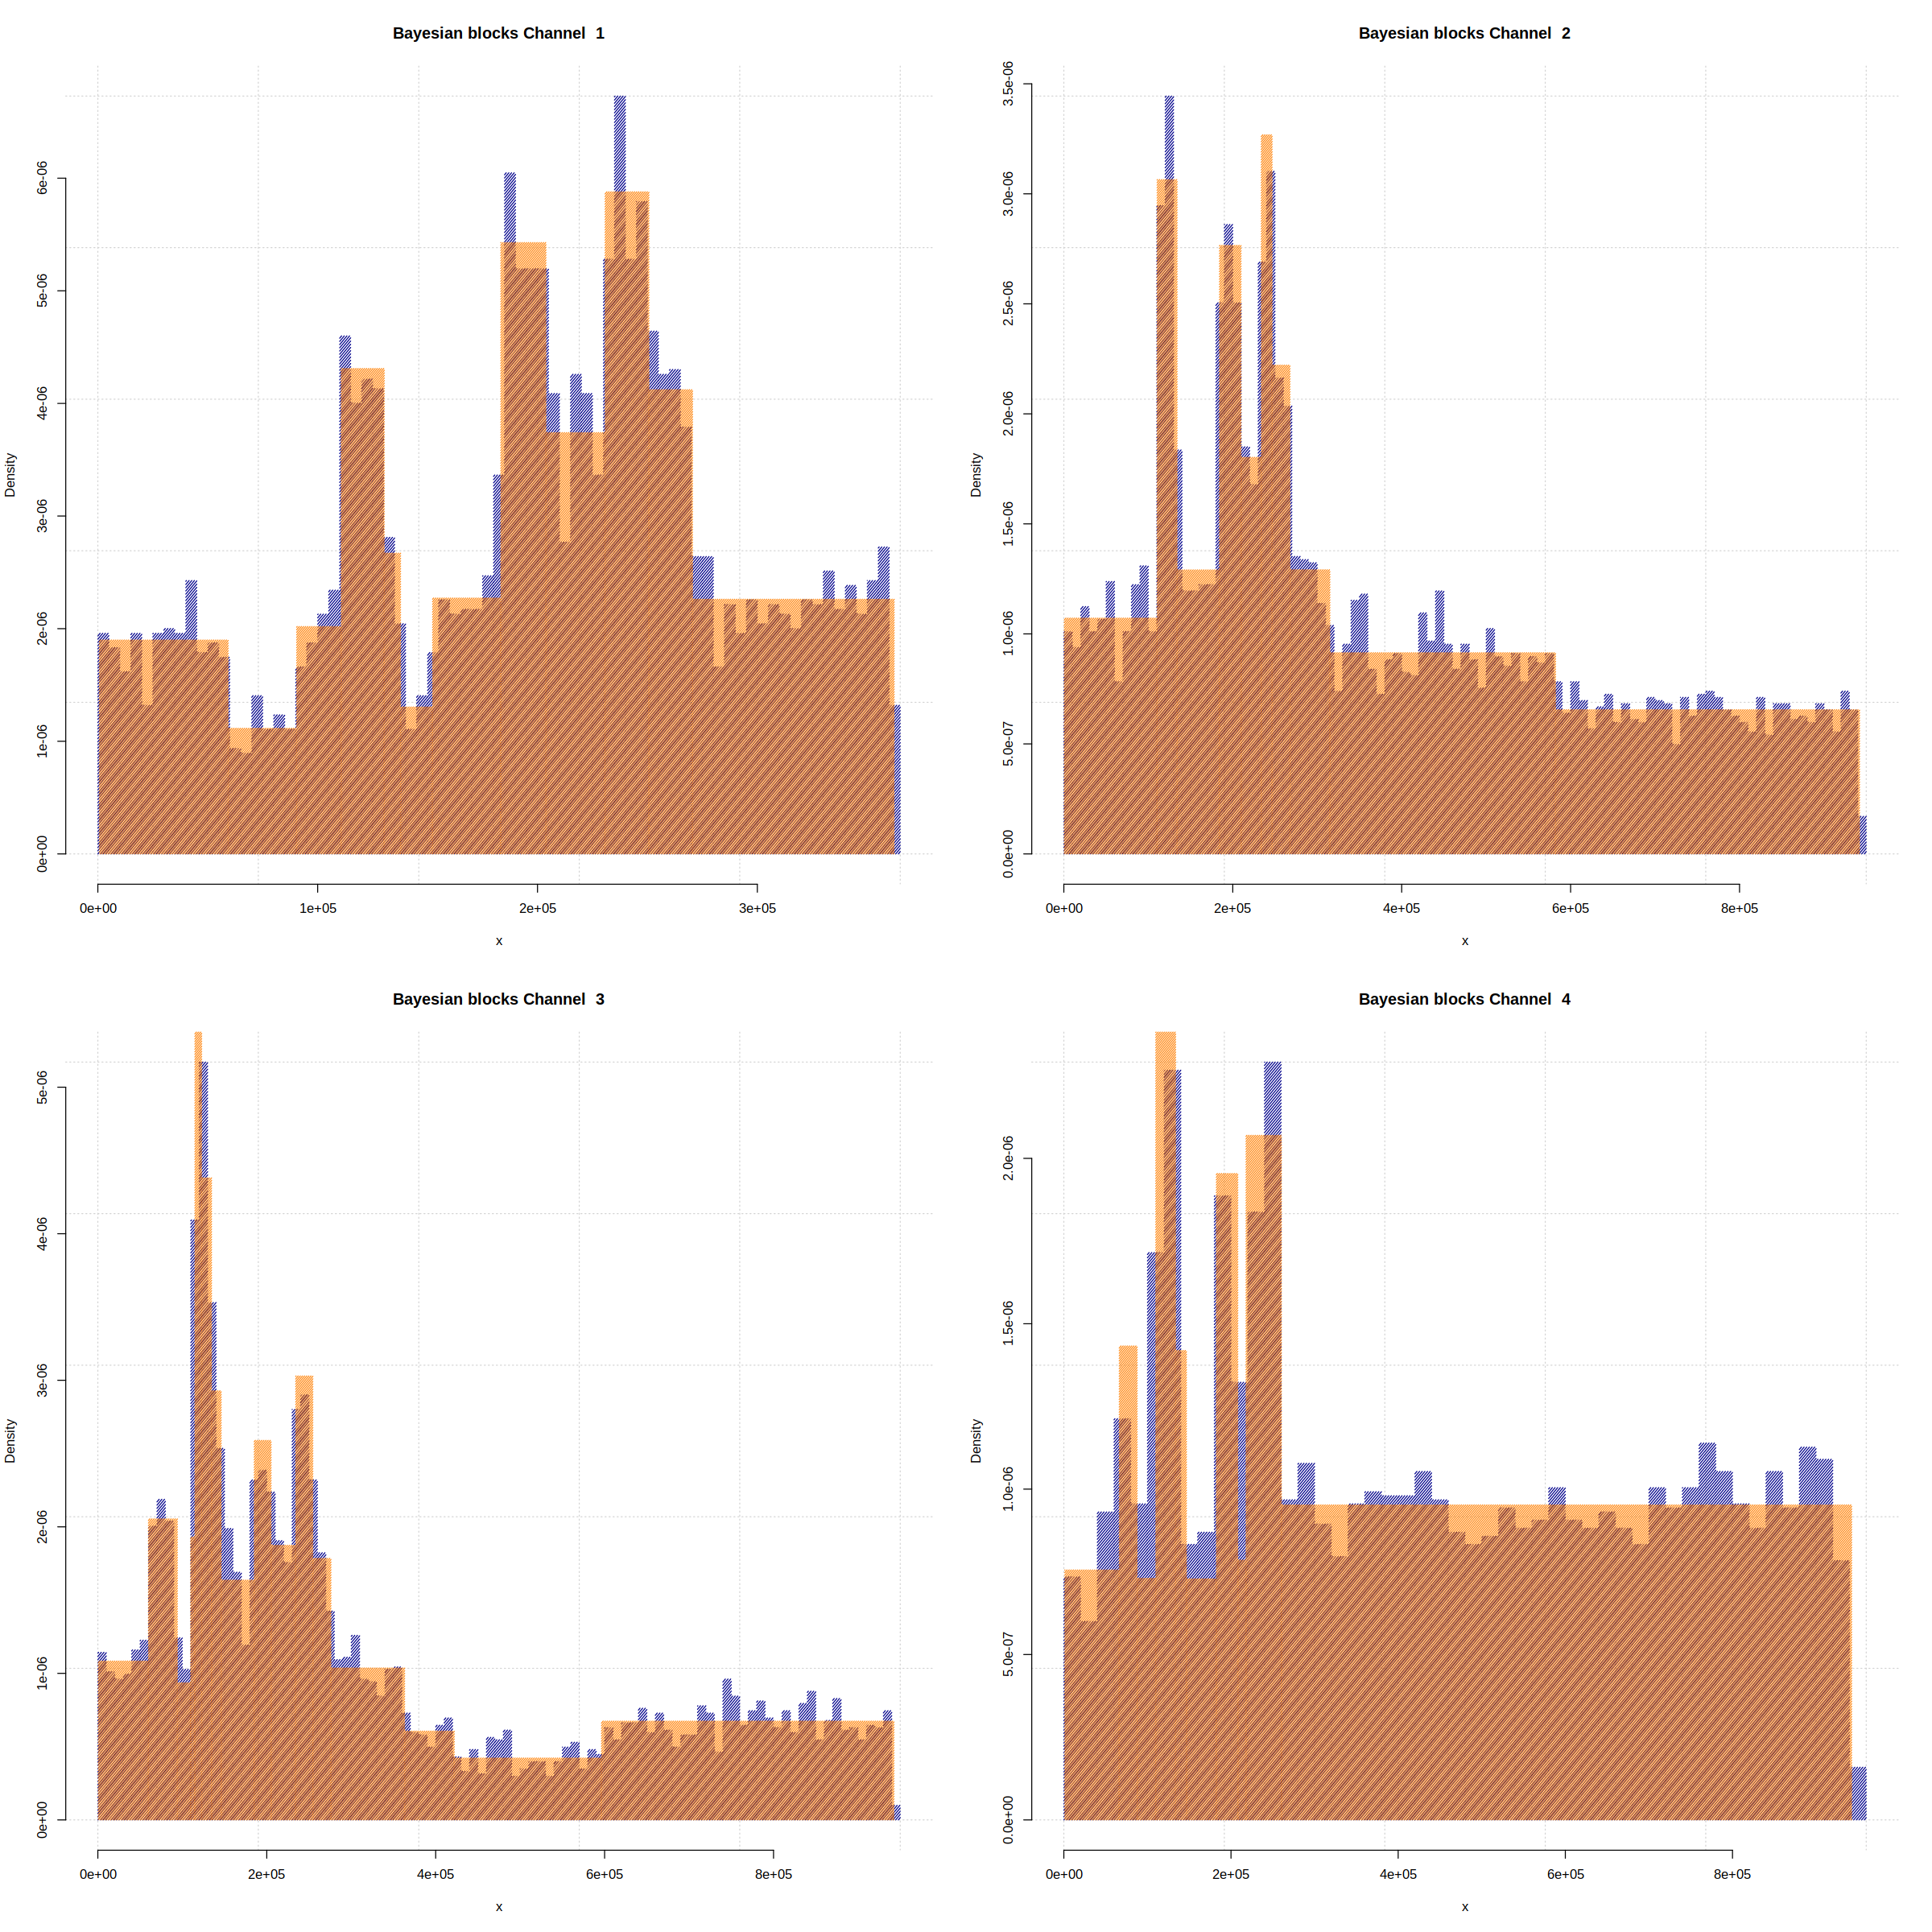

In [20]:
res_channels <- bb_channels(path)

### 4.1.3 Bootstrap analysis

To have a better understanding of the variance of the block light-curve, we can perform a bootstrap analysis.    
For the bootstrap analysis, due to the high computational time, I focused only on the most active area of channel 4, specifically: $[0.5\cdot 10^5, 3.0\cdot10^5]$        

The number of bootstrap samples is $N_{\text{samp}}=100$.

In [21]:
times <- c(0.5*10^5,3.0*10^5)

N_samp <- 100
ch <- 4

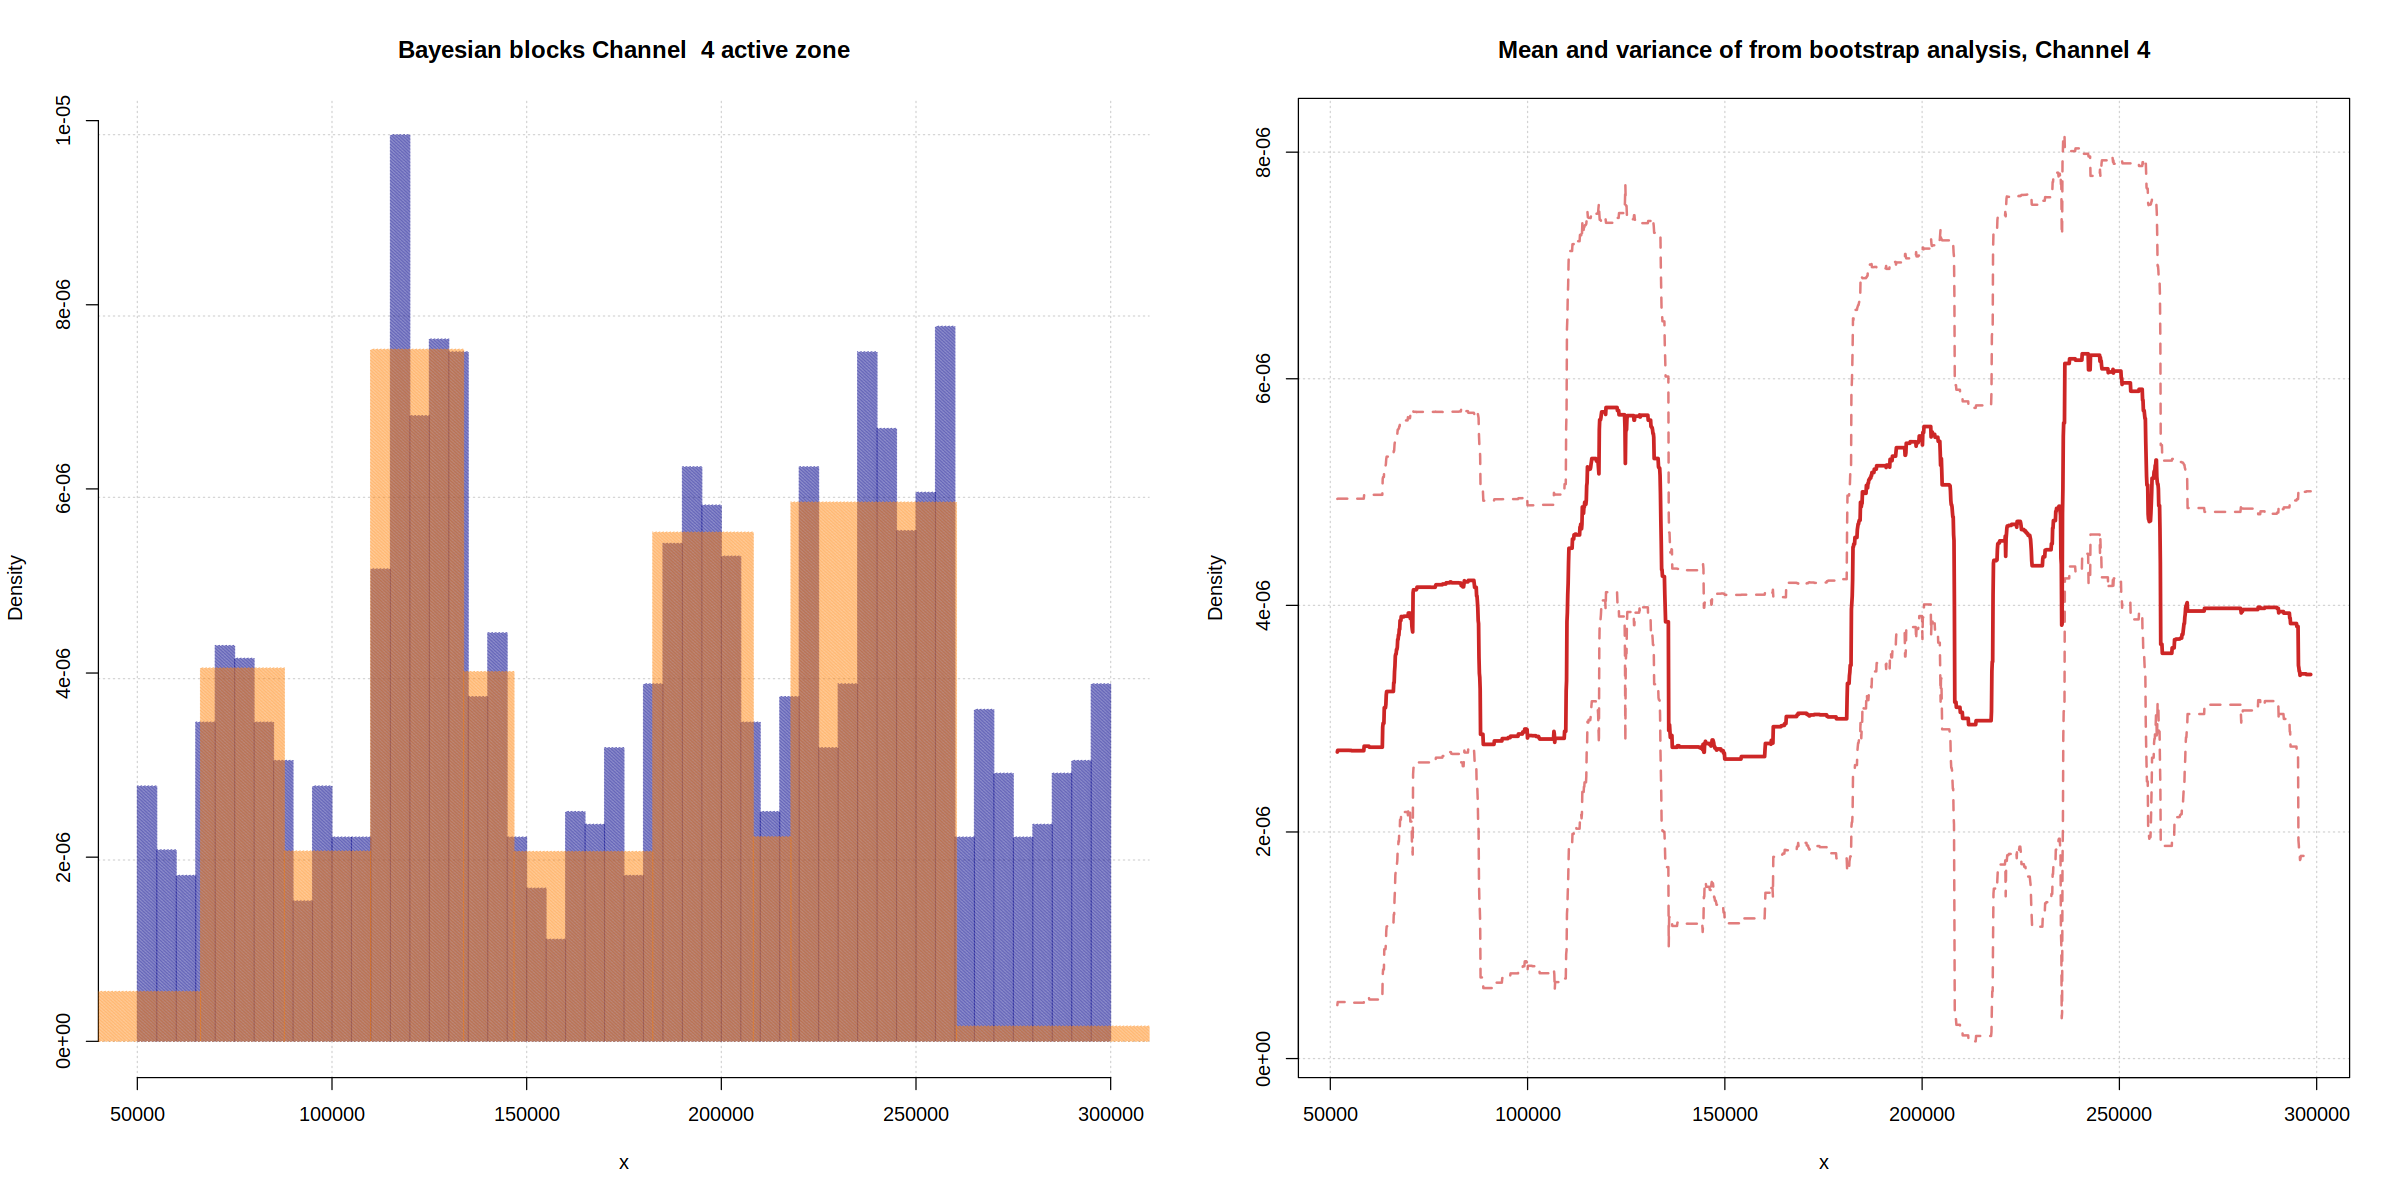

In [22]:
options(repr.plot.width=20,repr.plot.height=10)
par(mfrow=c(1,2))


# select data and edges of specific channel (from previous analysis)
channel_data <- res_channels$all_data[[ch]]
channel_bb <- res_channels$all_bb[[ch]]
    
# select subset corresponding to the chosen time interval for the channel
data_sub <- channel_data[channel_data$time>=times[1] & channel_data$time<=times[2],]
size_samp <- nrow(data_sub)    
    
#compute extremes for the histograms
m1 <- max(channel_bb[channel_bb<=min(data_sub[,1])])
m2 <- min(channel_bb[channel_bb>=max(data_sub[,1])])
idx1 <- which(channel_bb==m1)
idx2 <- which(channel_bb==m2)

#perform bootstrap
bs_analysis <- bootstrap_analysis(N_samp,data_sub,size_samp,'TTE',p0=.05,bin_width=100)
    
means <- bs_analysis$means
sigma_p <- bs_analysis$sigma_p
sigma_m <- bs_analysis$sigma_m
sel_times <- bs_analysis$sel_times
    
hist(data_sub[,1],breaks=sqrt(nrow(data_sub)),freq=FALSE,col=scales::alpha('darkblue',.6),border=F, panel.first=grid(),density=200,
    xlab='x',ylab='Density', main=paste('Bayesian blocks Channel ',ch, 'active zone'))
hist(data_sub[,1],breaks=channel_bb[idx1:idx2],density=200,freq=FALSE,col=scales::alpha('darkorange1',.55),border=F,add=T)
    
plot(sel_times, means, type='l', lwd=3, col='firebrick3',ylim=c(min(sigma_m),max(sigma_p)),
    panel.first=grid(),main=paste('Mean and variance of from bootstrap analysis, Channel',ch), xlab='x',
     ylab='Density')
lines(sel_times, sigma_p, type='l',lty=2,lwd=2, col=scales::alpha('firebrick3',.6))
lines(sel_times, sigma_m, type='l',lty=2, lwd=2, col=scales::alpha('firebrick3',.6))

The bootstrap analysis points out a visibly high variance around the mean, and this could be mainly due to two reasons:
- <font color='orange'>**A high variability in the original dataset**</font>: even small changes in the data can lead to significant differences in the resulting blocks, which are more evident in the 100 samples of the bootstrap analysis.
- <font color='orange'>**A small size of the samples**</font>: the datasets on which I performed the analysis were restricted mainly due to computational reasons; if the sample size is too small, the bootstrap samples might exhibit more variability because each resampled dataset might look significantly different from the others. 

## 4.2 Point measurements of KEPLER

The Kepler Mission, launched by NASA, collected high-precision, long-duration photometric observations of stars. The primary goal was to detect exoplanets by observing the transit method, where the flux (light intensity) of a star dips slightly as a planet passes in front of it.

The dataset [4] consists in the flux measurements of several thousand stars, for each of them a *fits* file is provided.    
In a single file, multiple columns are present; for the Bayesian Blocks algorithm, we need three columns:
- **'TIME'** : time series, times at which the flux is measured (in Barycentric Julian Date - 2454833);
- **'PDCSAP_FLUX'** : contains the values of the raw measured flux corrected and preprocessed to remove systematic errors (in electrons/sec);
- **'PDCSAP_FLUX_ERR'** : contains the associated errors.

[4] https://archive.stsci.edu/pub/kepler/lightcurves/0014/001429092/

In [23]:
file_path<-'kplr001429092-2009166043257_llc.fits'
kepler_data <- readFITS(file_path)

# inspect columns
kepler_data$colNames

[1] "TIME"            "TIMECORR"        "CADENCENO"       "SAP_FLUX"       
 [5] "SAP_FLUX_ERR"    "SAP_BKG"         "SAP_BKG_ERR"     "PDCSAP_FLUX"    
 [9] "PDCSAP_FLUX_ERR" "SAP_QUALITY"     "PSF_CENTR1"      "PSF_CENTR1_ERR" 
[13] "PSF_CENTR2"      "PSF_CENTR2_ERR"  "MOM_CENTR1"      "MOM_CENTR1_ERR" 
[17] "MOM_CENTR2"      "MOM_CENTR2_ERR"  "POS_CORR1"       "POS_CORR2"

In [24]:
time <- kepler_data$col[[1]] 
flux <- kepler_data$col[[8]]
flux_err <- kepler_data$col[[9]]


kepler_df <- data.frame( time = time, flux = flux, flux_err = flux_err)
na_ind <- which(is.na(kepler_df), arr.ind = TRUE)
kepler_df <- kepler_df[-(na_ind),]

In [25]:
edges <- bayesian_blocks(kepler_df, gamma=NULL, dt=NULL, data_type='PM',bool_time=FALSE,p0=0.95)
step_ <- steps(edges,kepler_df)

For a better visualization, I decided to show the results on the whole dataset as well as on a zoom-in of one of the peaks.

In [26]:
# define limits of the zoomed-in area
x_zoom_min <- min(kepler_df$time[300:700])
x_zoom_max <- max(kepler_df$time[300:700])
y_zoom_min <- min(kepler_df$flux[300:700])
y_zoom_max <- max(kepler_df$flux[300:700])

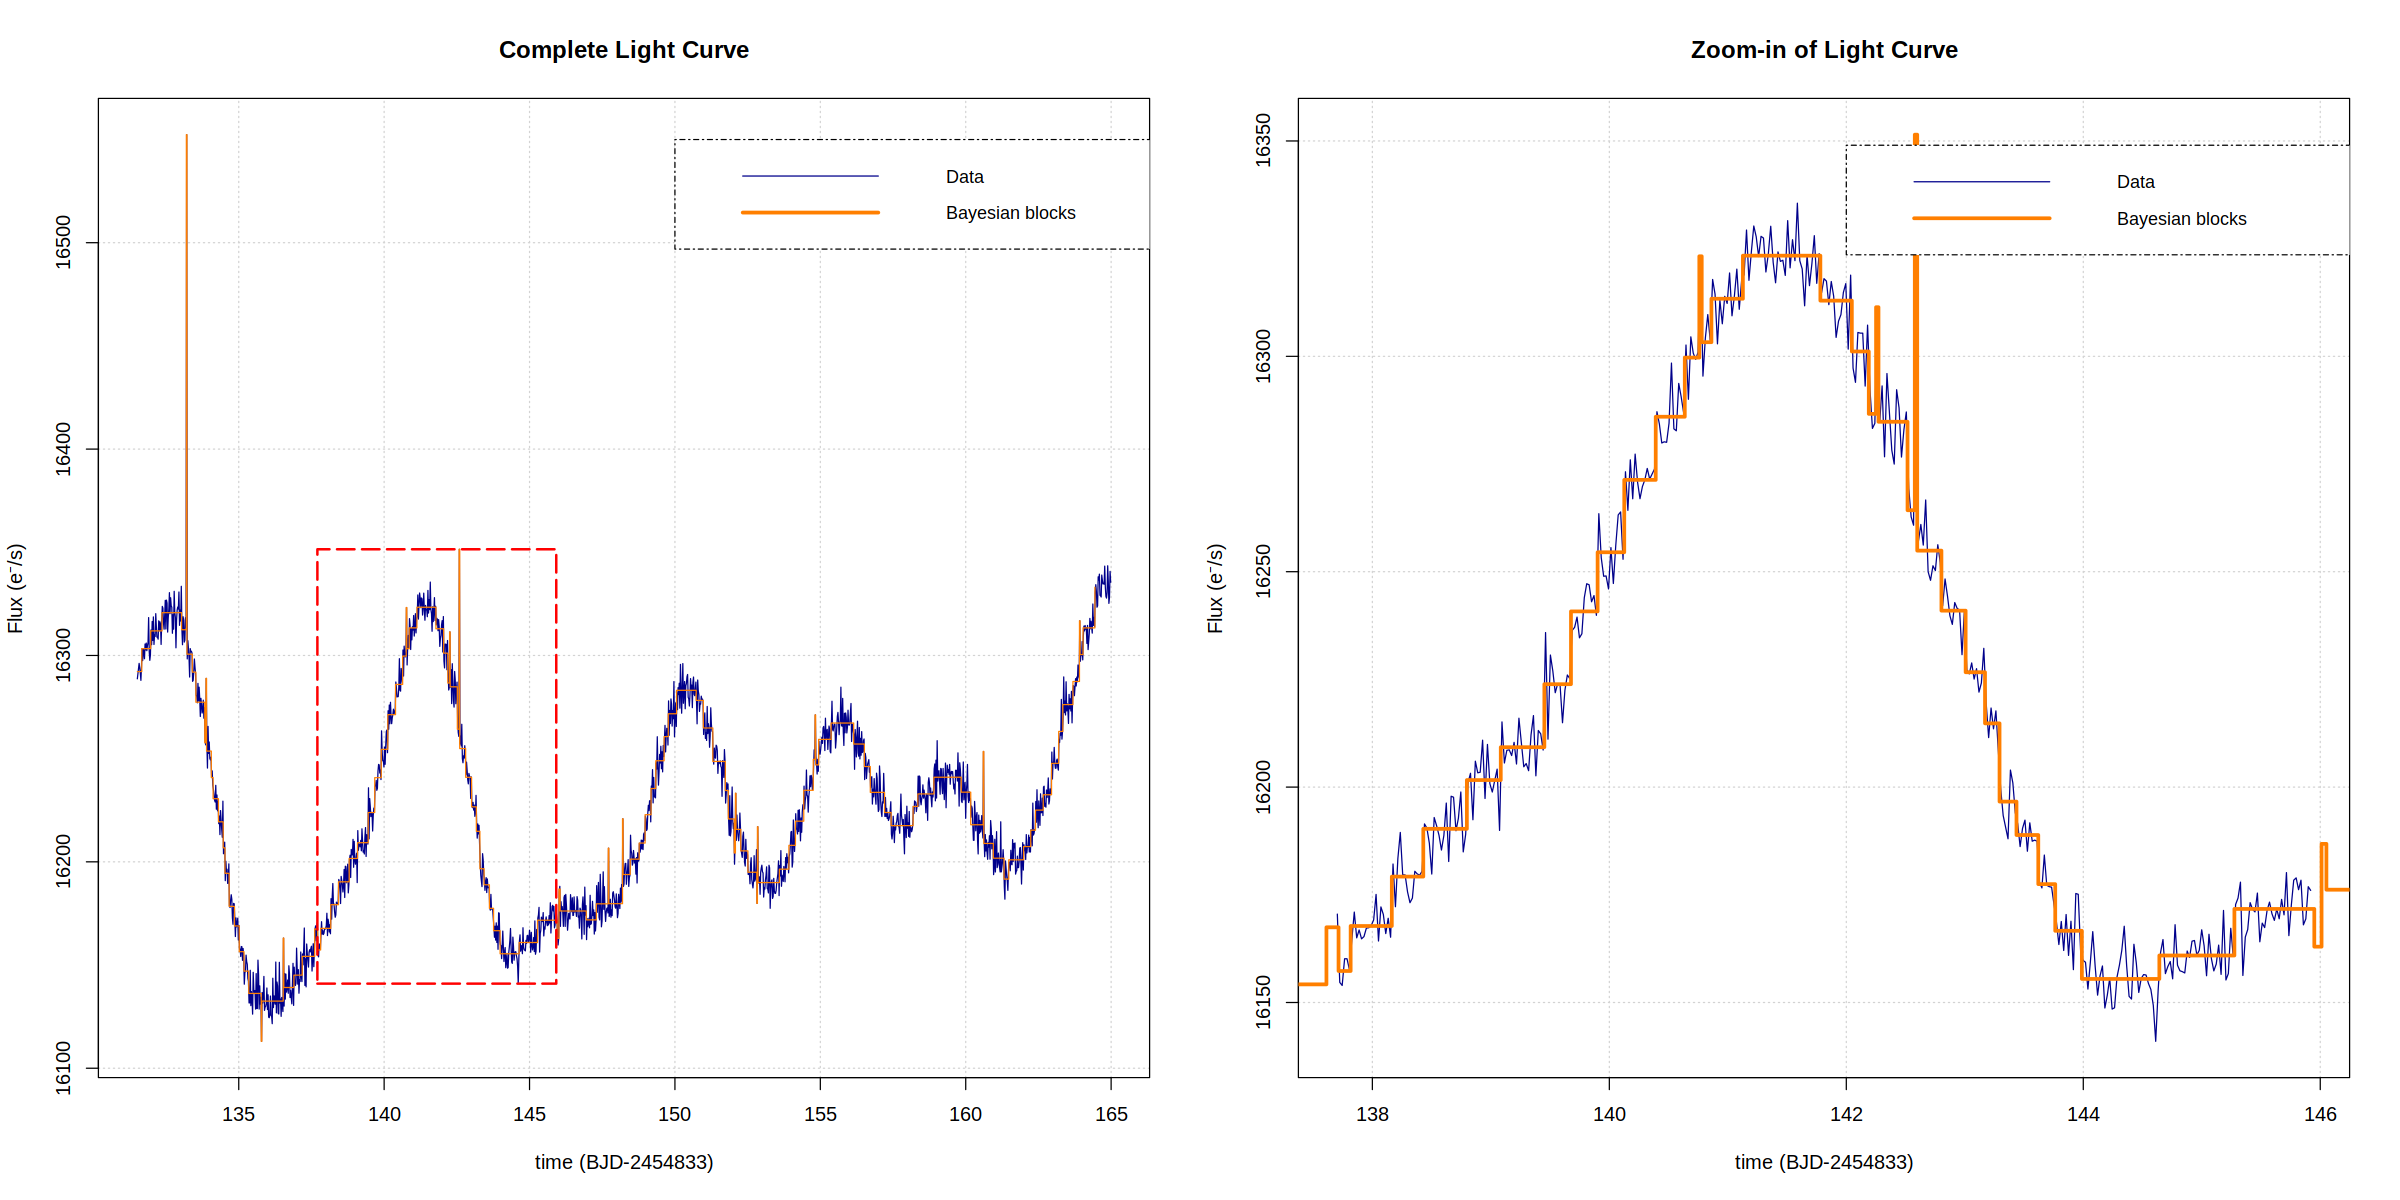

In [27]:
options(repr.plot.height=10,repr.plot.width=20)
par(mfrow=c(1,2))

plot(kepler_df$time, kepler_df$flux,col="darkblue", main="Complete Light Curve", type='l',panel.first=grid(),
     lwd=1, xlab="time (BJD-2454833)",ylab="Flux (e⁻/s)" )
lines(edges, step_ , type = "s", lwd = 1, col='darkorange1')
rect(x_zoom_min, y_zoom_min, x_zoom_max, y_zoom_max, border = "red", lwd = 2,lty=5)
legend(x=150,y=16550,legend=c("Data","Bayesian blocks"),
       col=c("darkblue","darkorange1"),lty=c(1,1),lwd=c(1,3), cex=0.9,box.lty=4, border=F)

plot(kepler_df$time[300:700], kepler_df$flux[300:700],col="darkblue", main="Zoom-in of Light Curve", type='l',panel.first=grid(),
     lwd=1, xlab="time (BJD-2454833)",ylab="Flux (e⁻/s)" )
lines(edges, step_ , type = "s", lwd = 3, col='darkorange1')
legend(x=142,y=16349,legend=c("Data","Bayesian blocks"),
       col=c("darkblue","darkorange1"),lty=c(1,1),lwd=c(1,3), cex=0.9,box.lty=4, border=F)


In this case, the result does not appear to be as good as in the TTE case. To make sure that the algorithm is, still, performing (even if not as good as before), I checked if $N_{\text{blocks}}<<N$, as it should:

In [28]:
N_b <- length(edges)+1
N <- nrow(kepler_df)
cat('Number of blocks: ', N_b, '\nNumber of observations: ', N)

Number of blocks:  131 
Number of observations:  1622

### 4.2.1. Bootstrap analysis

I then focused on one of the peaks to perform the bootstrap analysis and see the spread around the mean of the light-curves:

In [29]:
kepler_sub <-kepler_df[300:700,]
size_samp <- nrow(kepler_sub) 

bs_analysis <- bootstrap_analysis(100,kepler_sub,size_samp,'PM',p0=.05,bin_width=0.1)
means <- bs_analysis$means
sigma_p <- bs_analysis$sigma_p
sigma_m <- bs_analysis$sigma_m
sel_times <- bs_analysis$sel_times
    

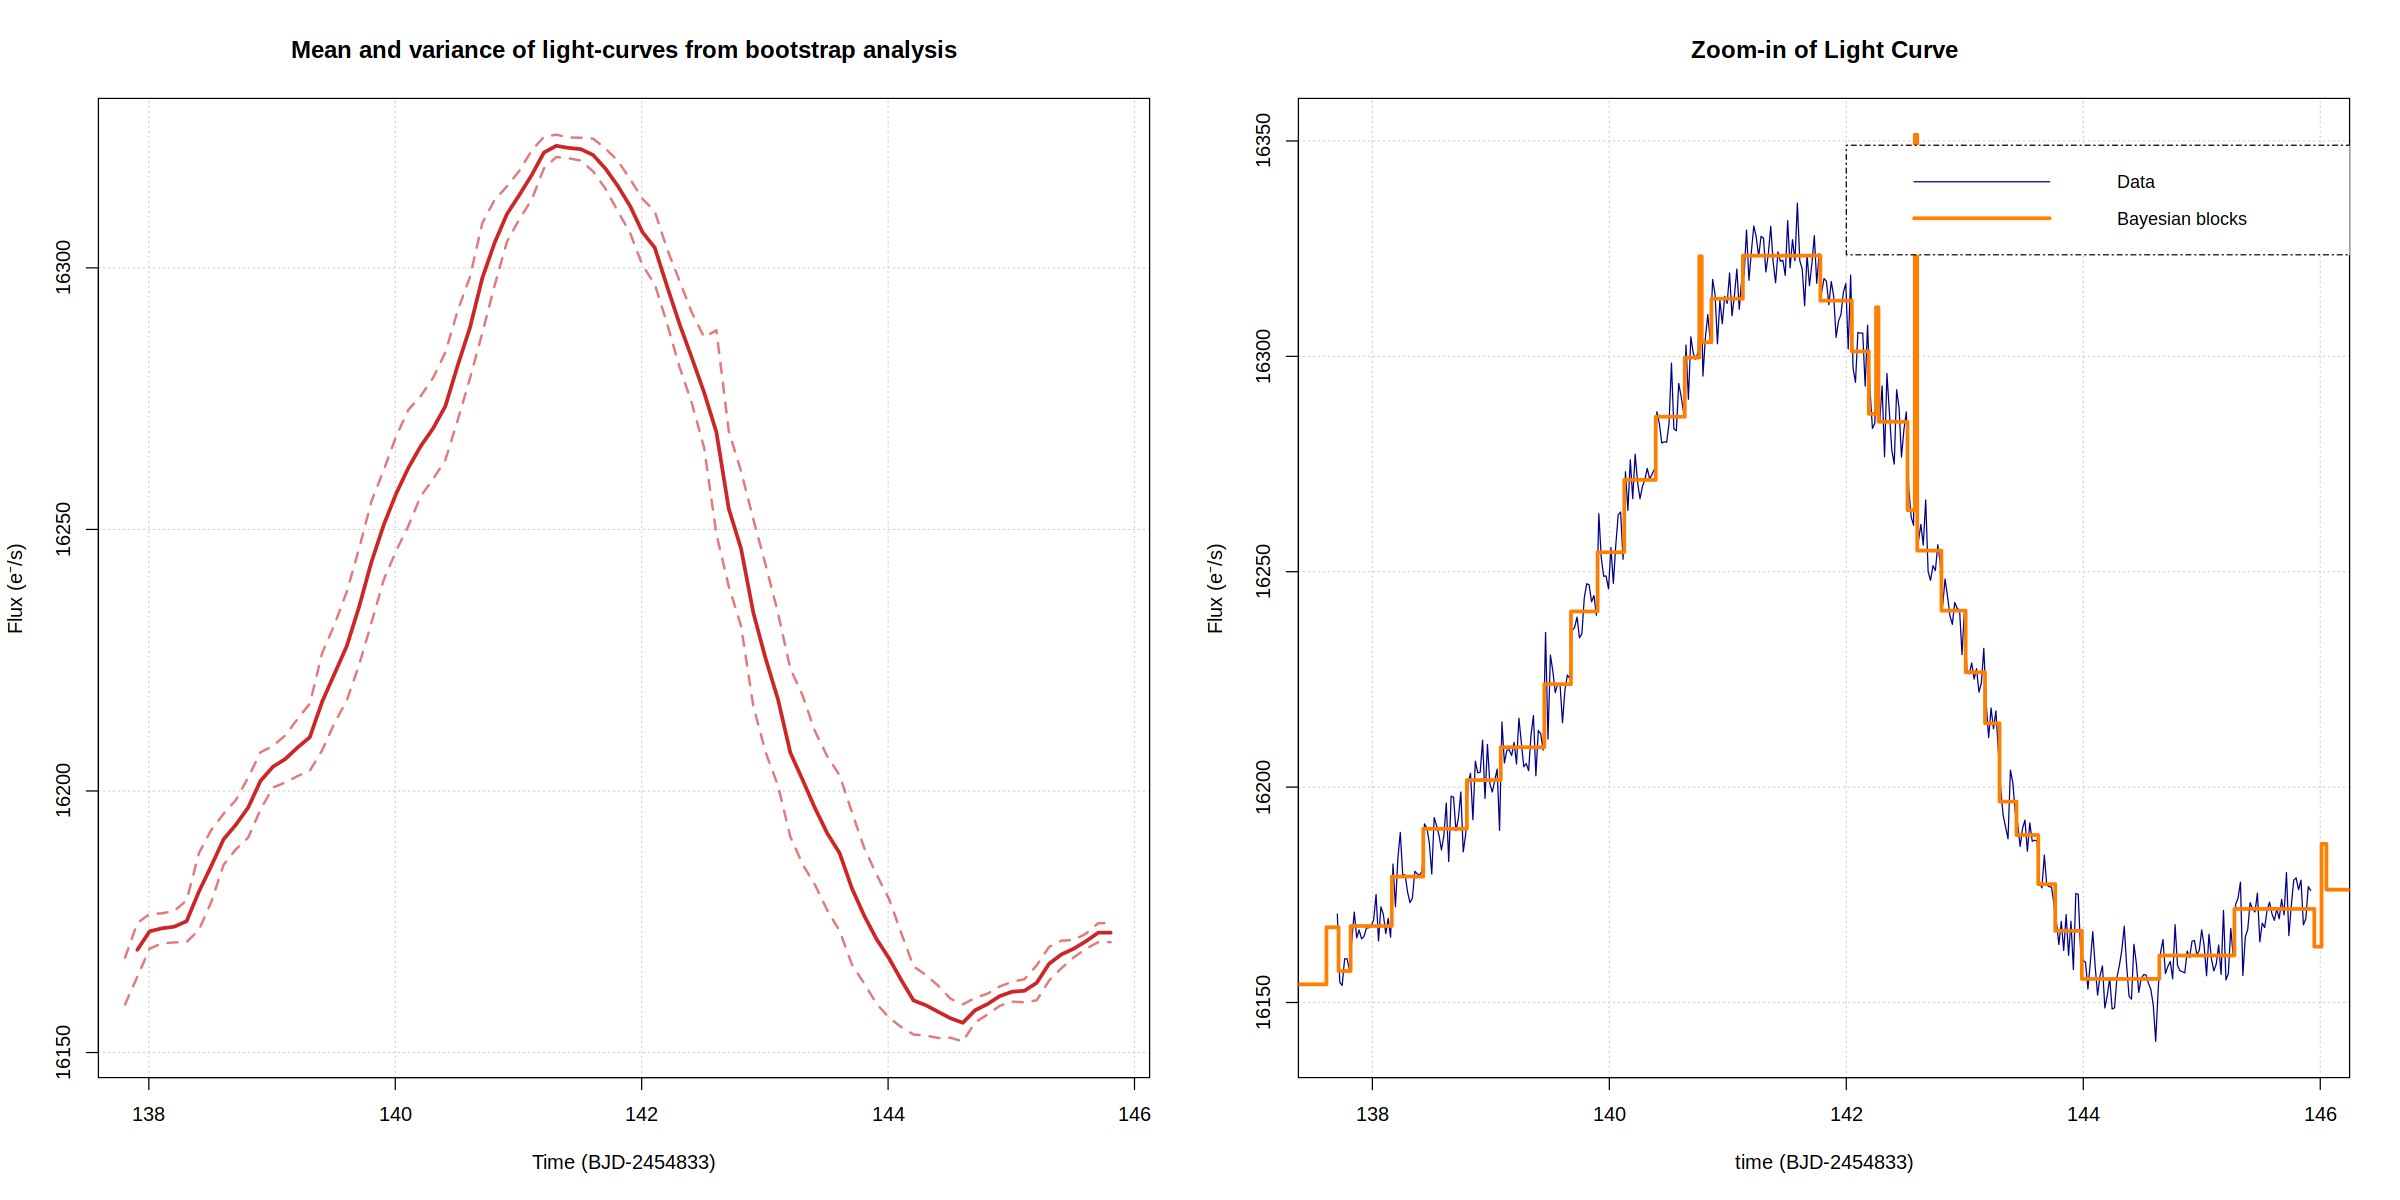

In [30]:
options(repr.plot.width=20,repr.plot.height=10)
par(mfrow=c(1,2))

plot(sel_times[-1], means[-1], type='l', lwd=3, col='firebrick3',ylim=c(min(sigma_m),max(sigma_p)),
    panel.first=grid(),main=paste('Mean and variance of light-curves from bootstrap analysis'), 
     xlab="Time (BJD-2454833)",ylab="Flux (e⁻/s)" )
lines(sel_times, sigma_p, type='l',lty=2,lwd=2, col=scales::alpha('firebrick3',.6))
lines(sel_times, sigma_m, type='l',lty=2, lwd=2, col=scales::alpha('firebrick3',.6))
    
plot(kepler_df$time[300:700], kepler_df$flux[300:700],col="darkblue", main="Zoom-in of Light Curve", type='l',panel.first=grid(),
     lwd=1, xlab="time (BJD-2454833)",ylab="Flux (e⁻/s)" )
lines(edges, step_ , type = "s", lwd = 3, col='darkorange1')
legend(x=142,y=16349,legend=c("Data","Bayesian blocks"),
       col=c("darkblue","darkorange1"),lty=c(1,1),lwd=c(1,3), cex=0.9,box.lty=4, border=F)


# 5. Conclusions

The implemented Bayesian Blocks algorithm efficiently manages to capture statistical important features in the case of TTE data, correctly differentiating between observational noise and significant variations and producing results which are comparable to the ones presented in the original paper, with a computational time in the order of $O(N^2)$ as expected.  
The bootstrap analysis showcases a high variance, issue that could be addressed by using a larger dataset for sampling, or could be due to a high variability of the data.

In the case of Point Measurements, the tendency to overfit appears more prominent, and the algorithm appears to not be able to distinguish as well between noise fluctuations and significant variations. 
This behaviour may be caused by irregular variations, or noise that the algorithm interprets as significant features, however it is important to notice that although the visual result looks less promising than in the TTE case, the number of blocks is much smaller than the size of the dataset, suggesting a good performance of the algorithm. 
The bootstrap analysis also points out how, on $100$ different bootstrap samples, the algorithm's block representation doesn't vary much around its mean, differently than what happened in the TTE case.    
  

Further improvements might focus on:
- a more in-depth preprocessing of the Point measurements data, involving additional filtering or smoothing techniques 
- a more thorough bootstrap analysis (with larger datasets or a larger number of samples) for TTE, to address the high variance issue.

